In [1]:
import numpy as np
import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

import torch

from glob import glob
#---Logger---#
from wandb.integration.sb3 import WandbCallback
import wandb
from motan.shaper_calibrate_simplified import freq_from_raw_data
from typing import Callable

from KOA.simulation import mzv_shaper,PRV,ERVA,zv_shaper,zvd_shaper,ideal_shaper,toolhead
from KOA.environment import PrinterV0,PrinterV2
from KOA.FeatureExtractor import RNN_Extractor,RNN_ExtractorV2,T5_Extractor
from KOA.shaper_calibrate import fit_shaper,shaper_score,SSR,get_shaper_smoothing
from typing import Callable

C:\Users\glass\.conda\envs\RL_Vibration\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

    STEPS_PER_EPISODE=50
    torch.autograd.set_detect_anomaly(True)
   # Example usage
    max_velocity = 1000 # mm/s
    acceleration = 10000 # mm/s^2
    time_step = 0.001  # s
    harmonic_frequency=29
    zeta=0.1
    use_wandb=False
    df = pd.read_csv('resonances_x_20240420_042935.csv')
    df_largest=df.nlargest(200, 'psd_x')
    frequencies=df_largest["freq"].to_numpy()
    amplitudes=df_largest["psd_x"].to_numpy()
    # amplitudes=df_largest["psd_xyz"].to_numpy()
    zetas=np.random.uniform(low=0.0,high=.05,size=frequencies.size)
    # frequency_response=[]
    frequency_response=np.vstack((amplitudes,frequencies,zetas))

    df_y = pd.read_csv('resonances_y_20240528_093025.csv')
    frequencies=df_y["freq"].to_numpy()
    amplitudes=df_y["psd_y"].to_numpy()
    zetas=np.random.uniform(low=0.0,high=.05,size=frequencies.size)
    frequency_response_y=np.vstack((amplitudes,frequencies,zetas))

    shaper=zvd_shaper(harmonic_frequency,zeta)
    klipper_dataset=[freq_from_raw_data(file) for file in glob("klipper_thread_dataset\**\\raw*.csv")]

    # moves=[50,150,5]#50,150,50,150]
    moves=[50,150,50]
    eval_env=PrinterV2(max_velocity,acceleration,time_step,shaper,[frequency_response,frequency_response_y],moves,STEPS_PER_EPISODE=STEPS_PER_EPISODE)
    eval_env.eval()
    eval_env.artificial_probability=0
    eval_env=Monitor(eval_env)
    config={}
    model=None

In [ ]:
res=fit_shaper(shaper, frequency_response_y)

In [ ]:
res.freq

In [ ]:
shaper.set_parameters(29.599999999999977,0.1)
erva(shaper,frequency_response_y)

In [ ]:
shaper_score(shaper,frequency_response_y)

In [6]:
# model=TD3.load("D:\\Users\\Otto Glass\\Documents\\Project\\Reinforcement-Learning-Examples\\models\\gwwniiga\\best_model\\best_model",env=eval_env,device="cpu")
model=TD3.load("D:\\Users\\Otto Glass\\Documents\\Project\\Reinforcement-Learning-Examples\\models\\y2u00hpk\\best_model\\best_model",env=eval_env,device="cpu")

Wrapping the env in a DummyVecEnv.


C:\Users\glass\.conda\envs\RL_Vibration\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.38GB > 3.05GB
  warnings.warn(


In [14]:
 # obs_i=eval_env.waveform
lst_r=[]

for j in range(500):
    obs,_= eval_env.reset()
    # obs_i=obs[0,:,1]
    time_start=0.3/eval_env.printer.time_step
    
    res=fit_shaper(shaper, eval_env.printer.frequency_response)
    shaper.set_parameters(res.freq,0.1)
    prnt=toolhead(acceleration,max_velocity,time_step,shaper,eval_env.printer.frequency_response)
    t,S=prnt.move(moves)
    obs_i=S[-int(time_start)-1:-1]
    A,T=prnt.shaper.get_impulses()
    prv_m=PRV(A,T,eval_env.printer.frequency_response)
    evra_r=ERVA(prnt.shaper,eval_env.printer.frequency_response)
    ssr_r=SSR(prnt.shaper,eval_env.printer.frequency_response)
    smoothing=get_shaper_smoothing(eval_env.printer.shaper)
    print(f"initial state {res.freq}Hz Ratio {0.1} PRV_m:{prv_m} EVRA: {evra_r} SSR: {ssr_r} smoothing: {smoothing}")
    data_start={'Frequency Start':res.freq,'Ratio Start':0.1,'PRV_m Start':prv_m,'EVRA Start':evra_r,'SSR Start':ssr_r,'smoothing_start': {smoothing}}
    movement=1
    for i in range(50):
        action, _states = model.predict(obs,deterministic=True)
        obs,_,truncated,terminated,info=eval_env.step(action)
        if truncated or terminated:
            break
    A,T=eval_env.printer.shaper.get_impulses()
    prv_m=PRV(A,T,eval_env.printer.frequency_response)
    evra_r=ERVA(eval_env.printer.shaper,eval_env.printer.frequency_response)
    ssr_r=SSR(eval_env.printer.shaper,eval_env.printer.frequency_response)
    smoothing=get_shaper_smoothing(eval_env.printer.shaper)
    print(f"Final PRV_m:{prv_m} EVRA: {evra_r} SSR: {ssr_r}  smoothing: {smoothing}")
    data_start.update({'PRV_m end':prv_m,'EVRA end':evra_r,'SSR_end':ssr_r,'smoothing_end': {smoothing}})
    lst_r.append(data_start)
    # obs_f=eval_env.waveform
    obs_f= eval_env.unwrapped.waveform[-int(time_start)-1:-1]
    # obs_f=obs[0,:,1]

result_df=pd.DataFrame(lst_r)

initial state 38.79999999999997Hz Ratio 0.1 PRV_m:15.512041087106004 EVRA: 0.020063774034940442 SSR: 0.003447415164222171 smoothing: 0.0013273935932217368
Final PRV_m:65.3980726132732 EVRA: 0.614637137838145 SSR: 0.0006118005315655942  smoothing: 0.0009951284320931213
initial state 38.79999999999997Hz Ratio 0.1 PRV_m:12.889456843125732 EVRA: 0.016873842331819777 SSR: 0.003183960888063766 smoothing: 0.0009951284320931213
Final PRV_m:1.01518715972176 EVRA: 0.0 SSR: 1.397197146404554e-05  smoothing: 0.001397197146404554
initial state 61.19999999999989Hz Ratio 0.1 PRV_m:13.660223243741182 EVRA: 0.00039494849251827996 SSR: 0.0008292542268776415 smoothing: 0.001397197146404554
Final PRV_m:1.7886402534749009 EVRA: 0.0 SSR: 1.4205847743806754e-05  smoothing: 0.0014205847743806754
initial state 61.19999999999989Hz Ratio 0.1 PRV_m:20.39356835577813 EVRA: 0.006565295269414952 SSR: 0.0009737971361126039 smoothing: 0.0014205847743806754
Final PRV_m:52.80654941341213 EVRA: 0.43751403772984976 SSR: 0

In [18]:
b=action[0:3]
b=b/b.sum()

In [19]:
b

array([7.8547191e-07, 9.9983704e-01, 1.6219995e-04], dtype=float32)

In [15]:
result_df.to_csv('results_TD3_PRV_V3.csv')
# obs_d=obs_f.copy()

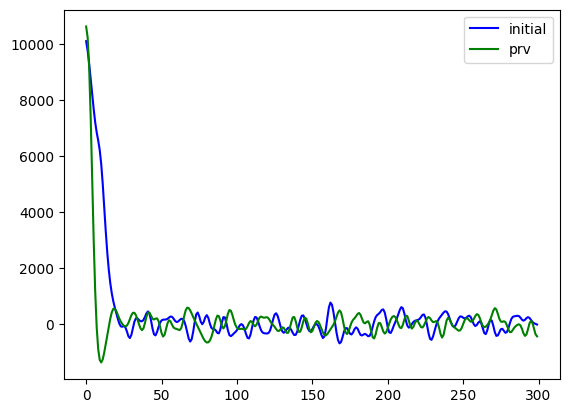

In [16]:
plt.plot(obs_i, color='b',label='initial')
# plt.plot(obs_d,color='r',label='score')
plt.plot(obs_f,color='g',label='prv')
# plt.plot(eval_env.ideal_curve,color='b')
plt.legend() 
plt.show()

In [19]:
obs_f

array([ 1.08322462e+04,  1.04993395e+04,  9.35324851e+03,  7.37571703e+03,
        4.88406810e+03,  2.39916619e+03,  4.03713632e+02, -8.44896933e+02,
       -1.35936203e+03, -1.34961951e+03, -1.09763149e+03, -8.32658638e+02,
       -6.51517061e+02, -5.18061715e+02, -3.37966352e+02, -5.72534518e+01,
        2.82560669e+02,  5.66338981e+02,  6.80706533e+02,  5.87704722e+02,
        3.54185387e+02,  1.23172132e+02,  3.68860751e+01,  1.48763988e+02,
        3.84338648e+02,  5.89182674e+02,  6.33953059e+02,  4.95864473e+02,
        2.59324812e+02,  4.86688506e+01, -5.03041133e+01, -3.01347752e+01,
        5.58352296e+01,  1.47517933e+02,  2.18304823e+02,  2.69843978e+02,
        3.03801487e+02,  3.11810011e+02,  2.90768679e+02,  2.58894841e+02,
        2.51160786e+02,  2.94998171e+02,  3.85714340e+02,  4.81364533e+02,
        5.20508402e+02,  4.54390625e+02,  2.83645330e+02,  7.87200952e+01,
       -5.00514390e+01, -3.54360237e+01,  7.84428959e+01,  1.63230530e+02,
        1.16773558e+02, -

In [9]:
dat=pd.DataFrame()

In [17]:
dat['obs_i']=obs_i
dat['obs_f']=obs_f
# dat['freq']=np.array([38.9,37.38190402984619])
dat.plot()

NameError: name 'dat' is not defined

In [12]:
obs_i[0]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
       0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
       0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125,
       0.126, 0.127,

In [ ]:
dat.to_csv('score_optimized.csv')

In [ ]:
dat

In [ ]:
from KOA.simulation import toolhead,ideal_shaper,PRV
eval_env.reset()
eval_env.state

In [ ]:
f=eval_env.printer.move([100,50,100,50,100,50,100])
plt.plot(f[0],f[1])
plt.show()

Graph Input Shaper Example

In [ ]:
shp=zvd_shaper(5,0)
a=shp.accelerate(0.01,3,1,np.array([[1],[5],[0]]))
tim=np.arange(0,3,0.01)
plt.plot(tim,a)
plt.show()

In [ ]:
def shaped_ideal_signal(shaper,time_step,total_time):
    t= np.arange(0, total_time, time_step)
    a=np.full(t.shape,0)
    total_len=len(a)
    A,T=shaper.get_impulses()
    A=A/A.sum()
    for i in range(0,len(A)):
        t2= np.arange(0, total_time-T[i], time_step)
        a2=np.full(t2.shape,A[i])
        diff=total_len-len(a2)
        a2=np.pad(a2,(diff,0))
        a=np.add(a,a2)
    return a

In [ ]:
e=shaped_ideal_signal(shp,0.01,3)

In [ ]:
example_df=pd.DataFrame()
example_df['shaped_commanded']=shaped_ideal_signal(shp,0.01,3)
example_df['shaped_output']=shp.accelerate(0.01,3,1,np.array([[1],[5],[0]]))
example_df['time']=tim
example_df['unshaped_commanded']=ideal_shaper.accelerate(0.01,3,1,[])
shp=zvd_shaper(0,0)
example_df['unshaped_output']=shp.accelerate(0.01,3,1,np.array([[1],[5],[0]]))

In [ ]:
example_df.to_csv('shaper_example.csv')